In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas


from skimage.feature import hog
from skimage.filters.rank import entropy
from skimage.morphology import disk

In [21]:
path_default='D:\Project Pattern\\archive\\chest_xray\\train'

train_norm_path='D:\\Project Pattern\\archive\\chest_xray\\train\\NORMAL'
train_pneumo_path='D:\\Project Pattern\\archive\\chest_xray\\train\\PNEUMONIA'


normal_names=os.listdir(train_norm_path)
pneu_names=os.listdir(train_pneumo_path)
print(len(normal_names))
print(len(pneu_names))


1341
3875


In [23]:
#Feature extraction


def hog_feature(image):  
    
    
    image=cv2.resize(image,(128,128))
    f = hog(image, orientations=8, pixels_per_cell=(32, 32),cells_per_block=(2, 2), visualize=False, multichannel=True)
    #plt.imshow(hog_image, cmap='gray')
    return f

def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    bins=8
  
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()
def fd_entropy(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image=np.mean(entropy(image, disk(5)))
    return image


In [24]:
labels=np.zeros((len(normal_names)+len(pneu_names),1))
labels[0:len(normal_names)]=0 #normal
labels[len(normal_names):]=1 #pneumonia

all_names=np.hstack((normal_names,pneu_names))
print(len(all_names))
print(all_names[len(normal_names)-5:len(normal_names)+5])


5216
['NORMAL2-IM-1406-0001.jpeg' 'NORMAL2-IM-1412-0001.jpeg'
 'NORMAL2-IM-1419-0001.jpeg' 'NORMAL2-IM-1422-0001.jpeg'
 'NORMAL2-IM-1423-0001.jpeg' 'person1000_bacteria_2931.jpeg'
 'person1000_virus_1681.jpeg' 'person1001_bacteria_2932.jpeg'
 'person1002_bacteria_2933.jpeg' 'person1003_bacteria_2934.jpeg']


In [25]:
from tqdm import tqdm
global_features=[]
for i in tqdm(range(len(all_names))):
    if i<len(normal_names):
        path=train_norm_path+'\\'+all_names[i]
    else:
        path=train_pneumo_path+'\\'+all_names[i]
    img=cv2.imread(path)
    img=cv2.resize(img,(300,300))

    
    
    fv_hu_moments = fd_hu_moments(img)
    #fv_entropy = fd_entropy(img)
    fv_haralick   = fd_haralick(img)
    fv_histogram  = fd_histogram(img)
    fv_hog=hog_feature(img)

        ###################################
        # Concatenate global features
        ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments,fv_hog])
    global_features.append(global_feature)




100%|██████████| 5216/5216 [07:03<00:00, 12.30it/s]


In [26]:
scaler            = MinMaxScaler(feature_range=(0, 1))
global_features = scaler.fit_transform(global_features)

In [27]:
al=np.array(global_features)
print(al.shape)

(5216, 820)


In [28]:
#TRAINING THE MODEL

import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
#from sklearn.externals import joblib

warnings.filterwarnings('ignore')


num_trees = 100
test_size = 0.10
seed      = 0
"""
train_path = "dataset/train"
test_path  = "dataset/test"
h5_data    = 'output/data.h5'
h5_labels  = 'output/labels.h5'
"""
scoring    = "accuracy"


In [29]:
models = []
models.append(('LR', LogisticRegression(random_state=seed,solver='newton-cg'))) # or solver='liblinear'
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3)))
#models.append(('CART', DecisionTreeClassifier(random_state=seed)))
#models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
#models.append(('NB', GaussianNB()))
models.append(('NB_com',ComplementNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

In [30]:
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (4694, 820)
Test data   : (522, 820)
Train labels: (4694, 1)
Test labels : (522, 1)


In [31]:
# TESTING THE BEST MODEL

test_norm_path='D:\\Project Pattern\\archive\\chest_xray\\val\\NORMAL'
test_pneumo_path='D:\\Project Pattern\\archive\\chest_xray\\val\\PNEUMONIA'


normal_names_test=os.listdir(test_norm_path)
pneu_names_test=os.listdir(test_pneumo_path)
print(len(normal_names_test))
print(len(pneu_names_test))

234
390


In [32]:
labels_test=np.zeros((len(normal_names_test)+len(pneu_names_test),1))
labels_test[0:len(normal_names_test)]=0 #normal
labels_test[len(normal_names_test):]=1 #pneumonia

all_names_test=np.hstack((normal_names_test,pneu_names_test))
print(len(all_names_test))
print(all_names_test[len(normal_names_test)-5:len(normal_names_test)+5])

624
['NORMAL2-IM-0374-0001.jpeg' 'NORMAL2-IM-0376-0001.jpeg'
 'NORMAL2-IM-0378-0001.jpeg' 'NORMAL2-IM-0380-0001.jpeg'
 'NORMAL2-IM-0381-0001.jpeg' 'person100_bacteria_475.jpeg'
 'person100_bacteria_477.jpeg' 'person100_bacteria_478.jpeg'
 'person100_bacteria_479.jpeg' 'person100_bacteria_480.jpeg']


In [33]:
#GET TEST FEATURES

global_features_test=[]
for i in tqdm(range(len(all_names_test))):
    if i<len(normal_names_test):
        path=test_norm_path+'\\'+all_names_test[i]
    else:
        path=test_pneumo_path+'\\'+all_names_test[i]
    img=cv2.imread(path)
    img=cv2.resize(img,(300,300))
    
    
    fv_hu_moments = fd_hu_moments(img)
    #fv_entropy = fd_entropy(img)
    fv_haralick   = fd_haralick(img)
    fv_histogram  = fd_histogram(img)
    fv_hog=hog_feature(img)

        ###################################
        # Concatenate global features
        ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments,fv_hog])
    global_features_test.append(global_feature)


100%|██████████| 624/624 [00:23<00:00, 26.07it/s]


In [34]:
scaler            = MinMaxScaler(feature_range=(0, 1))
global_features_test = scaler.fit_transform(global_features_test)


global_features_test=np.array(global_features_test)
labels_test=np.array(labels_test)

global_features=np.array(global_features)
labels=np.array(labels)


In [35]:
# 10-fold cross validation

for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, global_features, labels, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('Cross Validation Accuracy')
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)




Cross Validation Accuracy
LR: 0.960897 (0.019549)
Cross Validation Accuracy
KNN: 0.931555 (0.026057)
Cross Validation Accuracy
NB_com: 0.886486 (0.049008)
Cross Validation Accuracy
SVM: 0.954952 (0.017657)


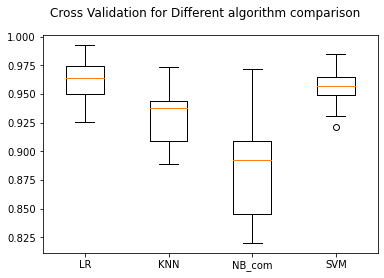

In [36]:
# boxplot algorithm comparison

fig = pyplot.figure()
fig.suptitle('Cross Validation for Different algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()


In [37]:
y_pred_all=[]
i=0
for name, model in models:
    model.fit(global_features, labels)
    y_pred = model.predict(global_features_test)
    print("For Model:",name,i)
    print(classification_report(labels_test,y_pred))
    y_pred_all.append(y_pred)
    i+=1

For Model: LR 0
              precision    recall  f1-score   support

         0.0       0.94      0.43      0.59       234
         1.0       0.74      0.98      0.85       390

    accuracy                           0.78       624
   macro avg       0.84      0.71      0.72       624
weighted avg       0.81      0.78      0.75       624

For Model: KNN 1
              precision    recall  f1-score   support

         0.0       0.92      0.54      0.68       234
         1.0       0.78      0.97      0.86       390

    accuracy                           0.81       624
   macro avg       0.85      0.76      0.77       624
weighted avg       0.83      0.81      0.79       624

For Model: NB_com 2
              precision    recall  f1-score   support

         0.0       0.72      0.41      0.53       234
         1.0       0.72      0.90      0.80       390

    accuracy                           0.72       624
   macro avg       0.72      0.66      0.66       624
weighted avg       0.

In [58]:
y_pred_all=np.array(y_pred_all)
print(y_pred_all.shape)
y_pred_new= y_pred_all[[0,1,3],:] #take only the best models(LR,KNN,SVM)
print(y_pred_new.shape)
avg_pred=np.mean(y_pred_new,axis=0)
print(avg_pred.shape)
avg_pred=avg_pred.astype(int)
print(classification_report(labels_test,avg_pred))

(4, 624)
(3, 624)
(624,)
              precision    recall  f1-score   support

         0.0       0.91      0.63      0.74       234
         1.0       0.81      0.96      0.88       390

    accuracy                           0.84       624
   macro avg       0.86      0.79      0.81       624
weighted avg       0.85      0.84      0.83       624



In [39]:
from scipy.io import savemat
savemat('test_features.mat',{'test_features':global_features_test})
savemat('test_labels.mat',{'test_labels':labels_test})
savemat('train_features.mat',{'train_features':global_features})
savemat('train_labels.mat',{'train_labels':labels})

Text(0.5, 1.0, 'HOG Features of pneumonia patient')

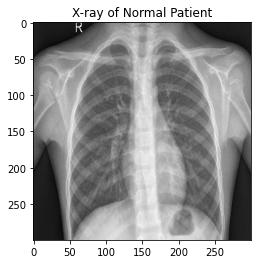

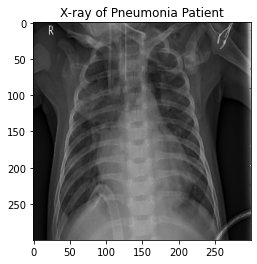

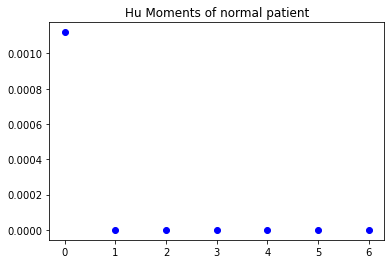

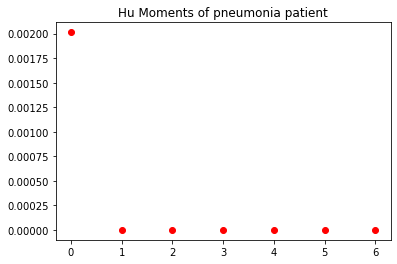

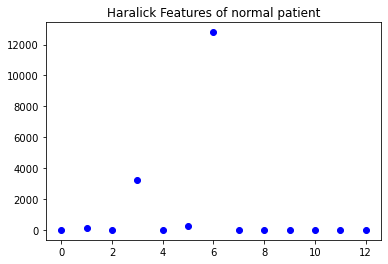

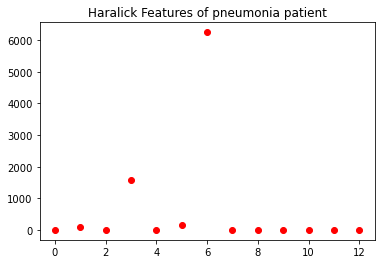

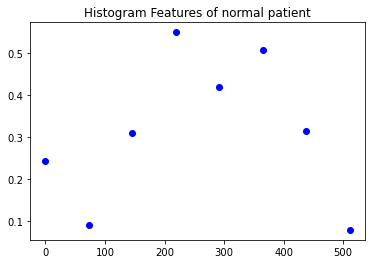

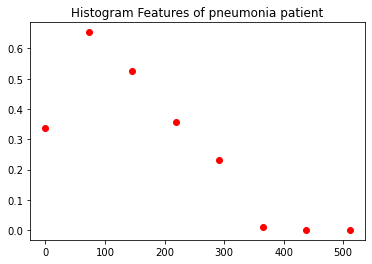

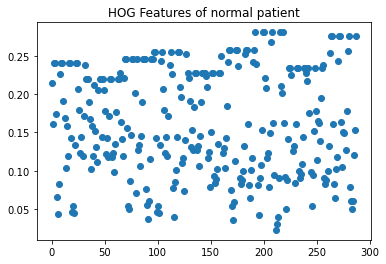

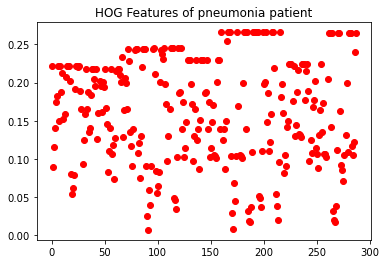

In [40]:
#____________________________________VISUALIZATION OF FEATURES_________________________________________
path=test_norm_path+'\\'+all_names_test[0]
img=cv2.imread(path)
img=cv2.resize(img,(300,300))
plt.figure()
plt.imshow(img)
plt.title('X-ray of Normal Patient')

path2=test_pneumo_path+'\\'+all_names_test[-10]
img2=cv2.imread(path2)
img2=cv2.resize(img2,(300,300))
plt.figure()
plt.imshow(img2)
plt.title('X-ray of Pneumonia Patient')


fv_hu_moments = fd_hu_moments(img)
fv_haralick   = fd_haralick(img)
fv_histogram  = fd_histogram(img)
fv_hog=hog_feature(img)

fv_hu_moments2 = fd_hu_moments(img2)
fv_haralick2  = fd_haralick(img2)
fv_histogram2  = fd_histogram(img2)
fv_hog2=hog_feature(img2)

plt.figure()
plt.scatter(np.arange(0,len(fv_hu_moments)),fv_hu_moments,color='b') #plotting the hu moments
plt.title('Hu Moments of normal patient')

plt.figure()
plt.scatter(np.arange(0,len(fv_hu_moments2)),fv_hu_moments2,color='r') #plotting the hu moments
plt.title('Hu Moments of pneumonia patient')

plt.figure()
plt.scatter(np.arange(0,len(fv_haralick)),fv_haralick,color='b') #plotting the haralick features
plt.title('Haralick Features of normal patient')

plt.figure()
plt.scatter(np.arange(0,len(fv_haralick2)),fv_haralick2,color='r') #plotting the haralick features
plt.title('Haralick Features of pneumonia patient')



plt.figure()
x=np.arange(0,len(fv_histogram))
x=x[fv_histogram!=0]
fv_histogram=fv_histogram[fv_histogram!=0]
plt.scatter(x,fv_histogram,color='b') #plotting the histogram features
plt.title('Histogram Features of normal patient')

plt.figure()
x=np.arange(0,len(fv_histogram2))
x=x[fv_histogram2!=0]
fv_histogram2=fv_histogram2[fv_histogram2!=0]
plt.scatter(x,fv_histogram2,color='r') #plotting the histogram features
plt.title('Histogram Features of pneumonia patient')


plt.figure()
plt.scatter(np.arange(0,len(fv_hog)),fv_hog) #plotting the hog features
plt.title('HOG Features of normal patient')


plt.figure()
plt.scatter(np.arange(0,len(fv_hog2)),fv_hog2,color='r') #plotting the hog features
plt.title('HOG Features of pneumonia patient')


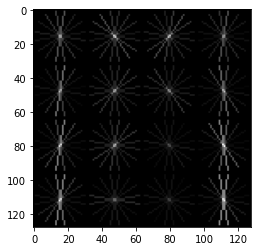

In [53]:
from skimage.feature import hog
path2=test_pneumo_path+'\\'+all_names_test[500]
img2=cv2.imread(path2)
img2=cv2.resize(img2,(128,128))
img2=cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
f, hog_image = hog(img2, orientations=8, pixels_per_cell=(32, 32),cells_per_block=(2, 2), visualize=True, multichannel=False)
plt.imshow(hog_image, cmap='gray')